In [18]:
import numpy as np
import numpy.linalg as LA
import jax
import jax.numpy as jnp
import jax.numpy.linalg as JLA

from jax.example_libraries import optimizers

import optax

import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from functools import partial
from sklearn.datasets import fetch_openml

In [5]:
A = jnp.array([[-0.2, 0.4, -1.0, -0.4],
    [-0.7, -0.8, -0.6, -0.3],
    [-0.2, 0.1, -0.2, 0.4],
    [-0.6, 0.8, -0.9, 0.3]])

In [8]:
eig, _ = JLA.eig(A)
print(eig)

[ 0.5799    +0.j         -0.5352528 +0.79588944j -0.5352528 -0.79588944j
 -0.40939507+0.j        ]


In [9]:
B = jnp.array([[-0.2, 0.1],
    [-0.7, -0.6],
    [0.6, 0.9],
    [-0.4, 0.4]])

In [10]:
C = jnp.array([[0.8, 0.8, -0.8, -0.9],
    [-0.7, 0.8, -0.8, -0.2]])

In [12]:
K = jnp.array([[-2.7, 2.7],
                [2.7, -2.7]])

In [14]:
eig, _ = JLA.eig(A + B @ K @ C)
print(eig)

[-0.17348303+1.6375853j -0.17348303-1.6375853j -0.696594  +0.j
 -0.15343916+0.j       ]


In [16]:
T = 20.0
N = 500
eta = T/N

In [20]:
def Euler(K):
    x = jnp.ones(4)
    x_trj = jnp.zeros((4, N))
    for i in range(N):
        x += eta * (A + B @ K @ C) @ x
        x_trj = x_trj.at[:, i].set(x)
    return x_trj[0,:], x_trj[1,:], x_trj[2,:], x_trj[3,:]

In [31]:
x1, x2, x3, x4 = Euler(K)
df = pd.DataFrame()
df["t"] = jnp.arange(eta, T+eta, eta)
df["x_1"] = x1
df["x_2"] = x2
df["x_3"] = x3
df["x_4"] = x4

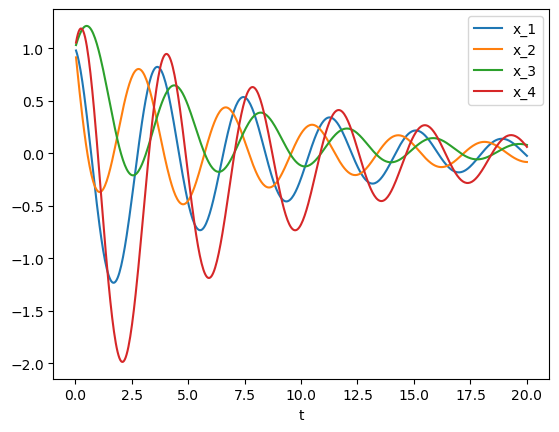

In [39]:
df.plot(df.columns[0], y = df.columns[1:]);